In [1]:
import numpy as np
import scipy.io
import pandas as pd
import pickle
from itertools import product
from typing import *
import os
from pathlib import Path
from tqdm import tqdm
from matplotlib import pyplot as plt
from fastplotlib import Plot
import seaborn as sns
from sklearn.linear_model import LogisticRegression

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Manual seed, do not change so this is reproducible.
### First 4 digits of pi for good luck lol

In [4]:
torch.manual_seed(3141)

# Load Data, do not touch

In [5]:
from scipy.io import loadmat

m = loadmat("/home/kushalk/repos/rnn-go-brr/rnngobrr/yuechen_data.mat")
m.keys()

dict_keys(['__header__', '__version__', '__globals__', 'all_directions_v2', 'direction_YQ1', 'realigned_traj_v2', 'traj_YQ1'])

In [6]:
train_directions = m["direction_YQ1"].flatten() - 1
train_directions

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1], dtype=uint8)

In [7]:
a = m['traj_YQ1']

traj_origin = (a.T - a[:, :, 0].T).T

In [8]:
traj_origin.shape

(156, 3, 151)

In [9]:
traj = np.zeros((traj_origin.shape[0], traj_origin.shape[1] + 1, traj_origin.shape[2]-1))
traj[:, :3, :] = traj_origin[:, :, 1:]
traj[:, -1, :] = train_directions.reshape(-1, 1)

### `[n_trials, x-y-z-target_direction, n_timepoints]`

# Do not touch, this was tedious af

In [10]:
inputs = dict()
targets = dict()
for i, d in zip(range(3), ["x", "y", "z"]):
    inputs[d] = torch.tensor(traj[:, i, 0], dtype=torch.float32)
    targets[d] = torch.tensor(traj[:, i, :], dtype=torch.float32)

all_inputs = torch.tensor(traj[:, :, 0], dtype=torch.float32)
all_targets = torch.tensor(traj[:, :, :], dtype=torch.float32)

In [11]:
all_inputs.shape

torch.Size([156, 4])

In [12]:
def get_init_point(direction: int, n_points: int) -> np.ndarray:
    get_means = lambda: all_inputs.mean(axis=0)
    get_stds  = lambda: all_inputs.std(axis=0)
    
    xyz0 = [np.random.normal(loc=get_means()[i], scale=get_stds()[i], size=n_points) for i in range(3)]
    dirs = [np.ones(n_points) * direction]

    return np.column_stack(xyz0 + dirs)

In [13]:
get_init_point(0, 6)

array([[-0.20948253,  0.48419578,  0.58597028,  0.        ],
       [ 0.27882656,  0.46150174, -0.04934237,  0.        ],
       [-0.26896917, -0.00181341,  0.71678571,  0.        ],
       [ 0.09226965, -0.14844841,  0.12649631,  0.        ],
       [ 0.15867173,  0.37757723,  0.07592759,  0.        ],
       [ 0.15446424,  0.37515952, -0.10351015,  0.        ]])

# This arch works pretty well

In [14]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
        )

        self.linear = nn.Linear(hidden_size, 3)

    def forward(self, x, hidden_prev):
        out, hidden_prev = self.rnn(x, hidden_prev)
        out = self.linear(out)
        out = out.unsqueeze(dim=0)
        return out, hidden_prev

### This is necessary for gradient explosion which I'm using to re-train the network after pruning, do not change. It will become clear after the pruning how it's used

In [15]:
class AscentFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        return input

    @staticmethod
    def backward(ctx, grad_input):
        return -grad_input


def make_ascent(loss):
    return AscentFunction.apply(loss)

# Logistic regression to classify if the trajectory reaches the left or right target

In [16]:
log_reg = LogisticRegression()
log_reg.fit(all_targets[:, :3, -1], train_directions)

def target_accuracy(predictions, target_directions):
    return np.count_nonzero(
        log_reg.predict(
            np.vstack([p[-1] for p in predictions])
        ) == target_directions
    ) / target_directions.size

# Training loop you can use to also test the pruned etc. models

In [17]:
def train(
    model: SimpleRNN,
    targets: torch.Tensor,
    optimizer: optim.Optimizer,
    lr0: int,
    loss_func: callable,
    n_epochs: int,
    gradient_ascent: bool = False,
    return_accuracy: bool = False
) -> SimpleRNN:
    """
    Parameters
    ----------

    SimpleRNN model instance

    `all_targets` created above

    optimizer, Adam seems to work well
    
    lr0, initial learning rate

    loss function, just MSE for now
    
    Returns
    -------
    
    SimpleRNN model instance, losses
    """

    losses = list()
    accs = list()
    hidden_prev = torch.zeros(1, 156, model.hidden_size).cuda()

    for n_epoch in tqdm(range(n_epochs)):
        # give position and target direction [x, y, z, direction] of only first index!
        x = all_targets.swapaxes(1, 2)[:, 0, :].reshape(156, 1, 4) # [n_trajs, 1, (x0, y0, z0, dir_0)]
        y = all_targets.swapaxes(1, 2)[:, :, :3]

        output, hidden_prev = model(x.cuda(), hidden_prev)
        hidden_prev = hidden_prev.detach()
        
        if not gradient_ascent:
            loss = loss_func(output, y.cuda())
        else:
            loss = make_ascent(loss_func(output, y.cuda()))
        
        model.zero_grad()
        loss.backward()
        optimizer.step()
        
        # reduces learnign rate every 250 epochs, this helps A LOT
        if n_epoch % 250 == 0:
            lr0 = lr0 / 10
            for g in optimizer.param_groups:
                g['lr'] = lr0

        losses.append(loss.detach().cpu().numpy().item())
        
        if return_accuracy:
            accs.append(target_accuracy_model(model, show_progress=False))
        else:
            accs = None
            
    
    return model, losses, accs

# Create the model

## these params seem to work well

In [18]:
torch.manual_seed(3141)

simple_rnn = SimpleRNN(
    input_size=4,
    hidden_size=2000,
    output_size=3,
).cuda()

In [19]:
lr = 0.001

simple_rnn, ls, ac = train(
    model=simple_rnn,
    targets=all_targets,
    optimizer=optim.Adam(simple_rnn.parameters(), lr),
    lr0=lr,
    loss_func=nn.MSELoss(),
    n_epochs=500
)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 631.48it/s]


# all losses and last 10 losses printed

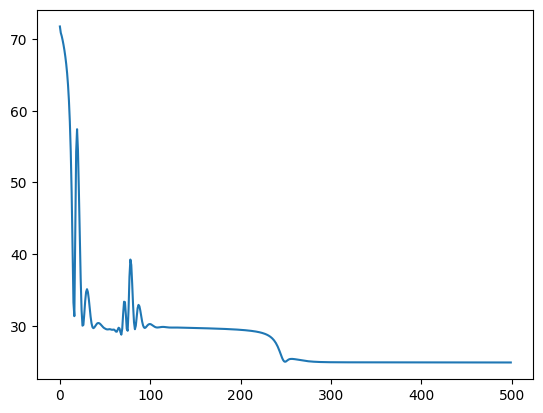

In [20]:
%matplotlib inline
plt.plot(ls)
plt.show()

### Last 10 losses, I get 24.8

In [21]:
ls[-10:]

[24.869638442993164,
 24.8695011138916,
 24.869384765625,
 24.869274139404297,
 24.86917495727539,
 24.869007110595703,
 24.86890411376953,
 24.868789672851562,
 24.86871337890625,
 24.868560791015625]

# Just a function to plot predictions

In [22]:
def plot_preds(model, inputs, directions):
    all_preds = torch.zeros(inputs.shape[0], 150, 3).cuda()

    hidden_prev = torch.zeros(1, inputs.shape[0], model.hidden_size).cuda()

    for timepoint in range(150):
        pred, hidden_prev = model(inputs.cuda(), hidden_prev.cuda())
        all_preds[:, timepoint, :] = pred[0, :, 0, :]

    cmap = {
        0: "r",
        1: "b"
    }

    ax = plt.figure().add_subplot(projection='3d')

    for p, d in zip(all_preds, directions):
        p = p.detach().cpu().numpy()
        ax.plot(p[:, 0], p[:, 1], p[:, 2], cmap[d], alpha=0.5)
    plt.show()
    return all_preds.detach().cpu().numpy()

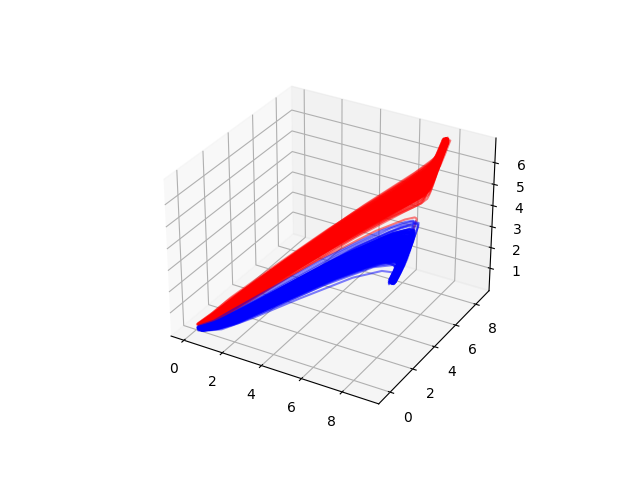

In [23]:
%matplotlib ipympl

n_points = 512
directions = np.array([0.] * int(n_points / 2) + [1.] * int(n_points / 2))
inputs = torch.tensor(np.vstack([get_init_point(0, int(n_points / 2)), get_init_point(1, int(n_points / 2))]), dtype=torch.float32).reshape(n_points, 1, 4).cuda()
preds_orig = plot_preds(simple_rnn, inputs, directions)

In [24]:
target_accuracy(preds_orig, target_directions=directions)

0.998046875

# Heatmap of weights

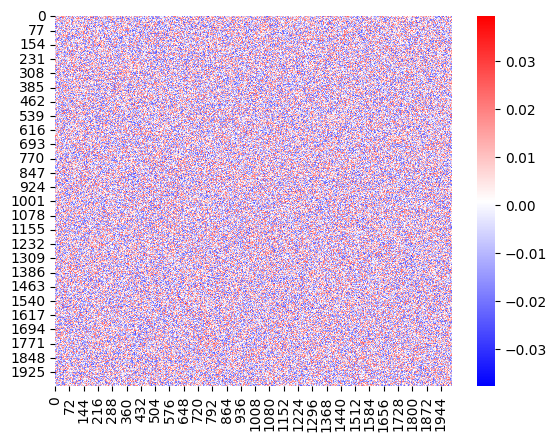

In [25]:
%matplotlib inline

sns.heatmap(simple_rnn.rnn.weight_hh_l0.detach().cpu().numpy(), cmap="bwr")
plt.show()

## Save the model first before pruning so we can have a copy

In [26]:
torch.save(simple_rnn.state_dict(), "./simple_rnn_2000.pt")

In [27]:
def get_orig_model() -> SimpleRNN:
    _m = SimpleRNN(
        input_size=4,
        hidden_size=2000,
        output_size=3,
    ).cuda()

    _m.load_state_dict(torch.load("./simple_rnn_2000.pt"))

    return _m

# Import pruning stuff

In [28]:
import torch.nn.utils.prune as prune

In [29]:
def plot_weights(models, fname: str = None):
    fig, axs = plt.subplots(nrows=3, ncols=4)
    fig.set_size_inches((8, 5))

    sns.heatmap(models[0].rnn.weight_hh_l0.detach().cpu().numpy(), cmap="seismic", ax=axs[0, 0], cbar=False)
    axs[0, 0].set_title("pre-pruned")

    for i, ax in tqdm(enumerate(axs.ravel()), total=11):
        if i == 0:
            ax.set_axis_off()
            continue  # skip the plot for the pre-pruned model
        if i == 11:
            break

        _pm = models[i - 1] # get one of the model instances for pruning

        # create a pruned model
        _pm.rnn = prune.random_unstructured(_pm.rnn, name="weight_hh_l0", amount=prune_fraction)

        sns.heatmap(_pm.rnn.weight_hh_l0.detach().cpu().numpy(), cmap="seismic", ax=ax, cbar=False)
        ax.set_title(f"pruned ix: {i -1}")
        ax.set_axis_off()

    plt.tight_layout()
    if fname is not None:
        plt.savefig(f"./figs/{fname}.png", dpi=300)

## Prune and verify

In [30]:
%matplotlib inline

prune_fraction = 0.1

# create 10 model instances to prune
pruned_models_0_1: List[SimpleRNN] = [get_orig_model() for i in range(10)]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:44<00:00,  4.07s/it]


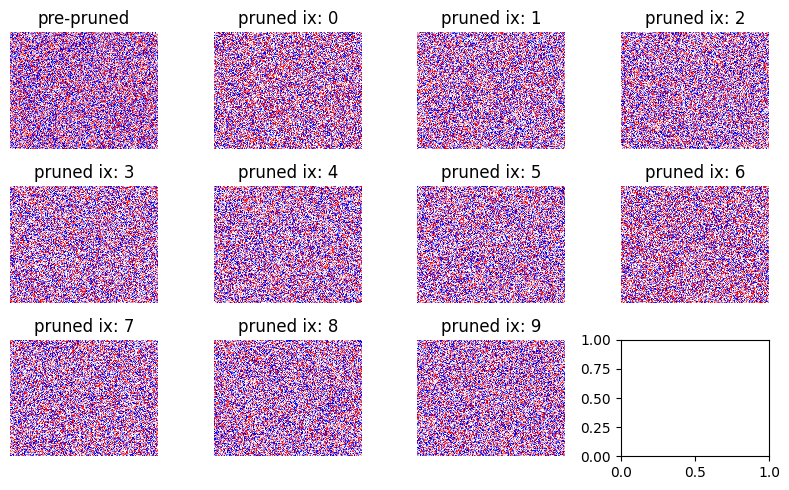

In [31]:
plot_weights([get_orig_model()] + pruned_models_0_1, "weights_10percent.png")
plt.show()

In [33]:
def plot_preds_grid(models, inputs, directions, fname: str = None):
    cmap = {
        0: "r",
        1: "b"
    }

    accs = list()

    fig, axs = plt.subplots(nrows=3, ncols=4, subplot_kw=dict(projection="3d"))
    fig.set_size_inches((12, 10))

    for i, (model, ax) in tqdm(enumerate(zip(models, axs.ravel()))):
        all_preds = torch.zeros(inputs.shape[0], 150, 3).cuda()

        hidden_prev = torch.zeros(1, inputs.shape[0], model.hidden_size).cuda()

        for timepoint in range(150):
            pred, hidden_prev = model(inputs.cuda(), hidden_prev.cuda())
            all_preds[:, timepoint, :] = pred[0, :, 0, :]

        for p, d in zip(all_preds, directions):
            p = p.detach().cpu().numpy()
            ax.plot(p[:, 0], p[:, 1], p[:, 2], cmap[d], alpha=0.5)
        acc = target_accuracy(all_preds.detach().cpu().numpy(), directions)
        ax.set_title(f"{acc * 100:.2f}%")
        
        if i == 10:
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            ax.set_zlabel("z")
        
        accs.append(accs)
        
    if fname is not None:
        plt.savefig(f"./figs/{fname}.png", dpi=300)
        
    return accs

# Predictions with pruned model!

11it [00:03,  3.31it/s]


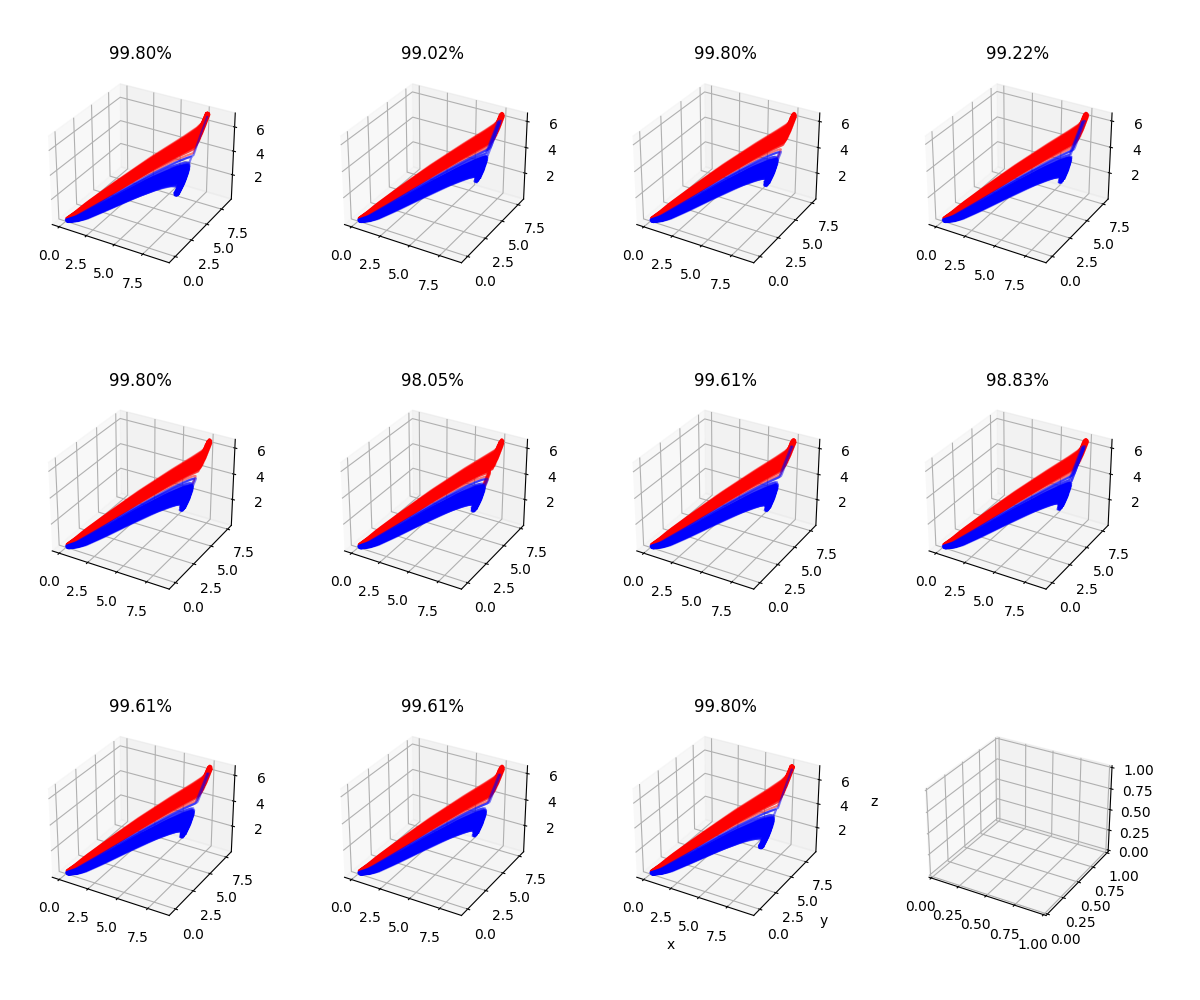

In [34]:
%matplotlib ipympl
# inputs = all_targets.swapaxes(1, 2)[:, 0, :].reshape(156, 1, 4)
n_points = 512
directions = np.array([0.] * int(n_points / 2) + [1.] * int(n_points / 2))
inputs = torch.tensor(np.vstack([get_init_point(0, int(n_points / 2)), get_init_point(1, int(n_points / 2))]), dtype=torch.float32).reshape(n_points, 1, 4).cuda()

models = [simple_rnn] + pruned_models_0_1

accs_0_1 = plot_preds_grid(models, inputs, directions, fname="10perecent_trajs")
plt.tight_layout()
plt.show()

In [35]:
accs_all = list()
accs_all.append(accs_0_1)

# Prune 20%

100%|████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:43<00:00,  3.92s/it]


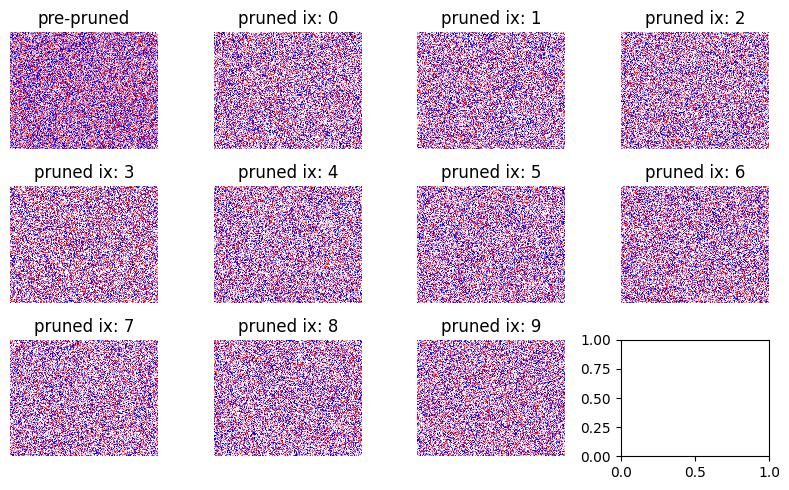

In [36]:
%matplotlib inline

prune_fraction = 0.2

# create 10 model instances to prune
pruned_models_0_2: List[SimpleRNN] = [get_orig_model() for i in range(10)]

plot_weights([get_orig_model()] + pruned_models_0_2, "weights_20percent")
plt.show()

11it [00:03,  3.15it/s]


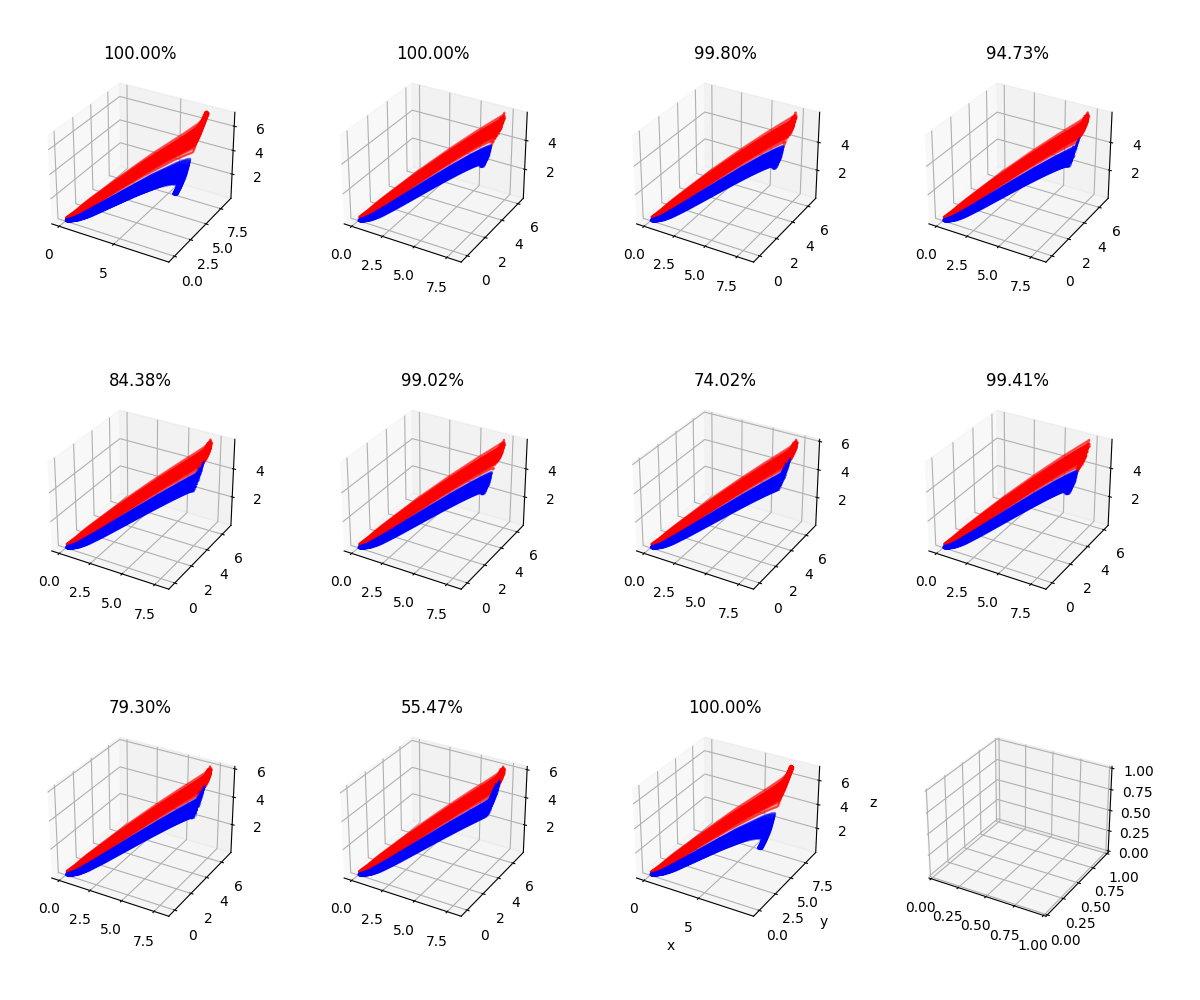

In [37]:
%matplotlib ipympl
# inputs = all_targets.swapaxes(1, 2)[:, 0, :].reshape(156, 1, 4)
n_points = 512
directions = np.array([0.] * int(n_points / 2) + [1.] * int(n_points / 2))
inputs = torch.tensor(np.vstack([get_init_point(0, int(n_points / 2)), get_init_point(1, int(n_points / 2))]), dtype=torch.float32).reshape(n_points, 1, 4).cuda()

models = [simple_rnn] + pruned_models_0_2

accs_0_2 = plot_preds_grid(models, inputs, directions, fname="20perecent_trajs")
plt.tight_layout()
plt.show()

# Prune 35%

100%|████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:43<00:00,  3.95s/it]


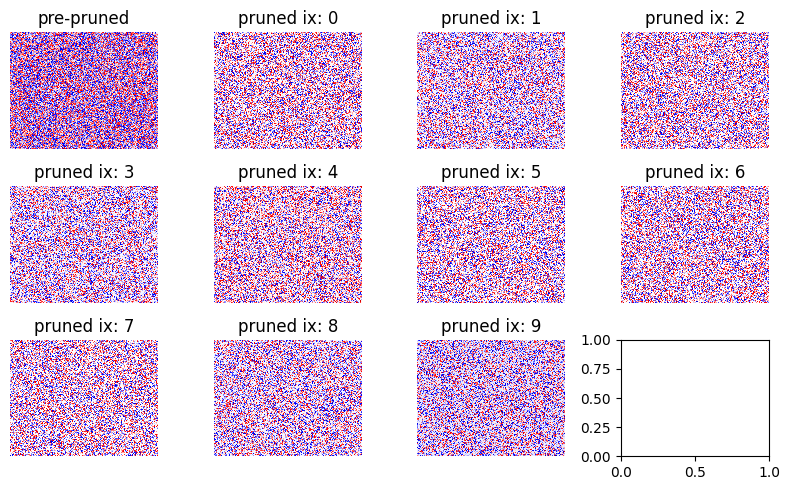

In [38]:
%matplotlib inline

prune_fraction = 0.35

# create 10 model instances to prune
pruned_models_0_35: List[SimpleRNN] = [get_orig_model() for i in range(10)]

plot_weights([get_orig_model()] + pruned_models_0_35, "weights_35percent")
plt.show()

11it [00:03,  2.90it/s]


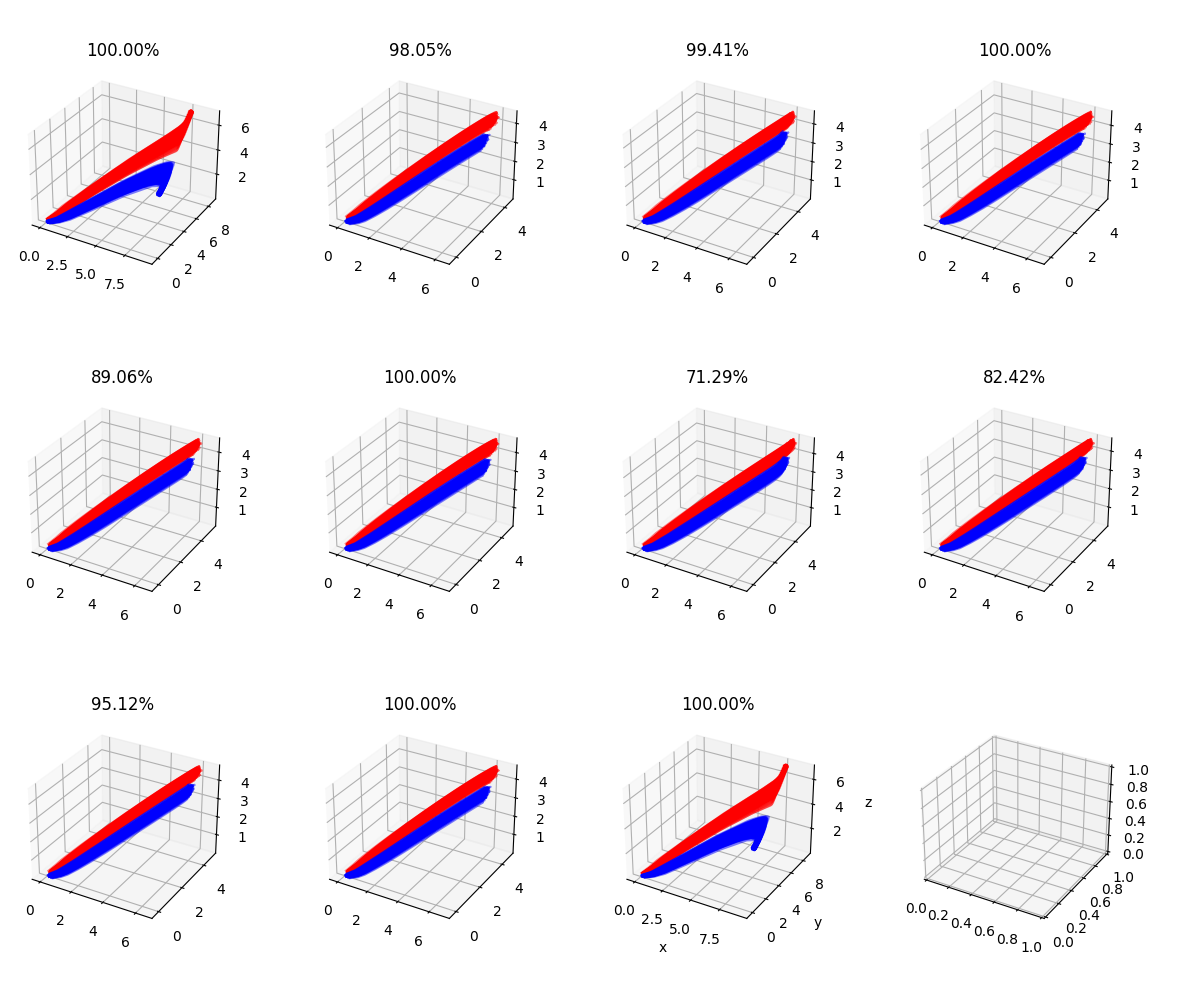

In [39]:
%matplotlib ipympl
# inputs = all_targets.swapaxes(1, 2)[:, 0, :].reshape(156, 1, 4)
n_points = 512
directions = np.array([0.] * int(n_points / 2) + [1.] * int(n_points / 2))
inputs = torch.tensor(np.vstack([get_init_point(0, int(n_points / 2)), get_init_point(1, int(n_points / 2))]), dtype=torch.float32).reshape(n_points, 1, 4).cuda()

models = [simple_rnn] + pruned_models_0_35

accs_0_35 = plot_preds_grid(models, inputs, directions, fname="35perecent_trajs")
plt.tight_layout()
plt.show()

# Prune 50%

In [ ]:
%matplotlib inline

prune_fraction = 0.50

# create 10 model instances to prune
pruned_models_0_50: List[SimpleRNN] = [get_orig_model() for i in range(10)]

plot_weights([get_orig_model()] + pruned_models_0_50, "weights_50percent")
plt.show()

 55%|██████████████████████████████████████████████████▋                                          | 6/11 [00:14<00:14,  2.99s/it]

11it [00:02,  3.69it/s]


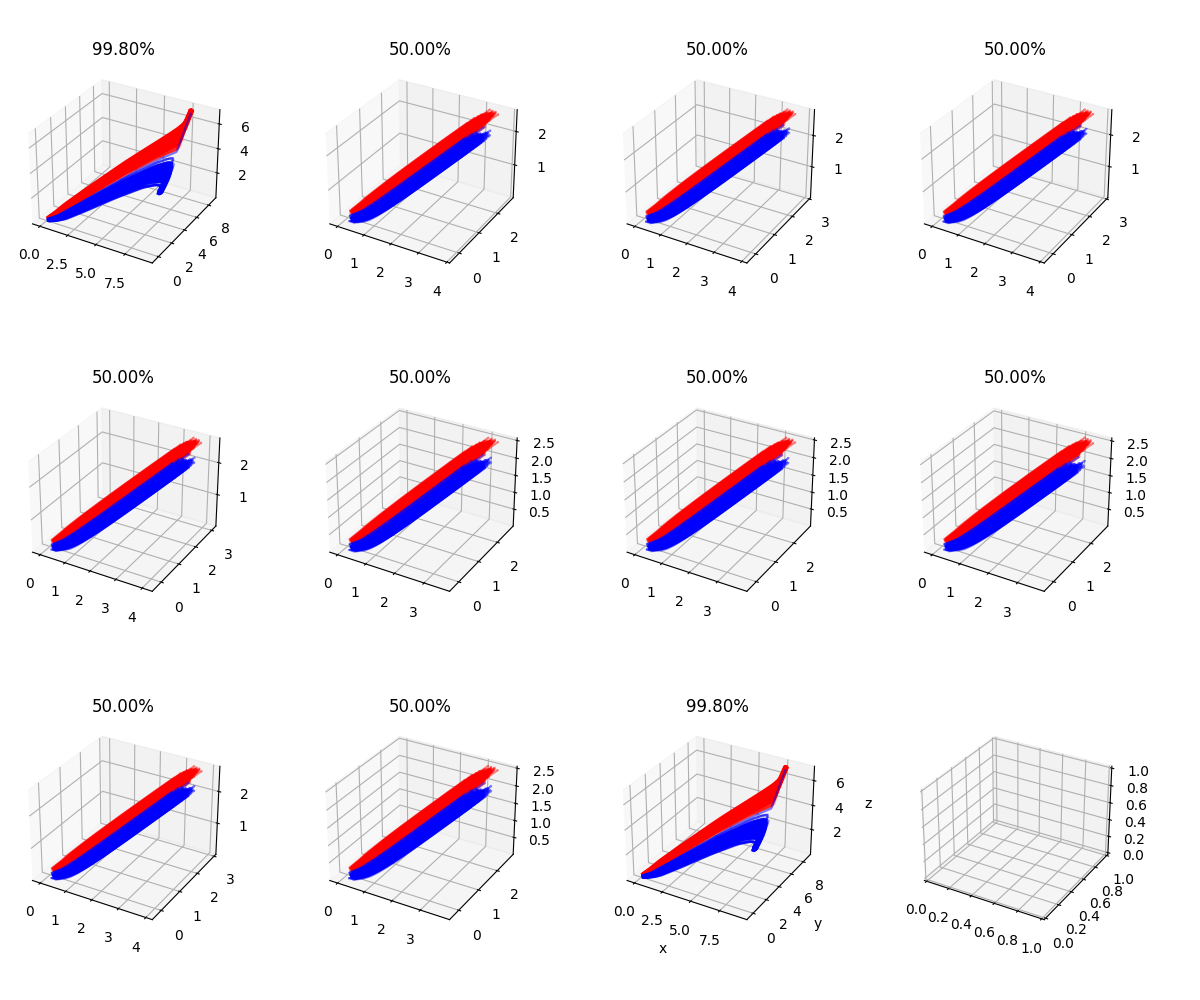

In [100]:
%matplotlib ipympl
# inputs = all_targets.swapaxes(1, 2)[:, 0, :].reshape(156, 1, 4)
n_points = 512
directions = np.array([0.] * int(n_points / 2) + [1.] * int(n_points / 2))
inputs = torch.tensor(np.vstack([get_init_point(0, int(n_points / 2)), get_init_point(1, int(n_points / 2))]), dtype=torch.float32).reshape(n_points, 1, 4).cuda()

models = [simple_rnn] + pruned_models_0_50

accs_0_50 = plot_preds_grid(models, inputs, directions, fname="50perecent_trajs")
plt.tight_layout()
plt.show()

# Retrain with no-gradient explosion

In [128]:
lr = 0.0001

prune_rnn_no_ascent, ls, ac = train(
    model=prune_rnn_no_ascent,
    targets=all_targets,
    optimizer=optim.Adam(prune_rnn_no_ascent.parameters(), lr),
    lr0=lr,
    loss_func=nn.MSELoss(),
    n_epochs=30,
    gradient_ascent=False,
    return_accuracy=True
)

  0%|                                                                                  | 0/30 [00:00<?, ?it/s]/home/kushalk/python-venvs/stor566/lib/python3.9/site-packages/torch/nn/modules/rnn.py:471: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.rnn_tanh(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/kushalk/python-venvs/stor566/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([156, 150, 3])) that is different to the input size (torch.Size([1, 156, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  3%|██▍                        

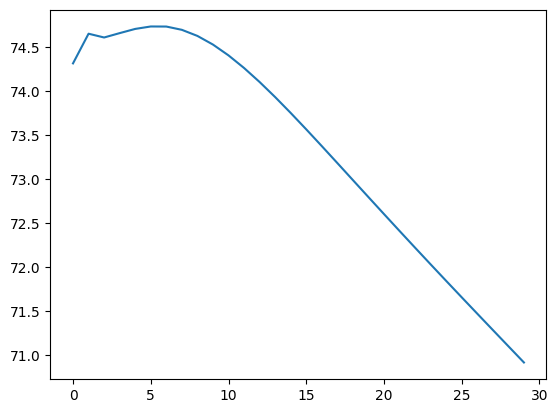

Text(0.5, 1.0, 'accuracy')

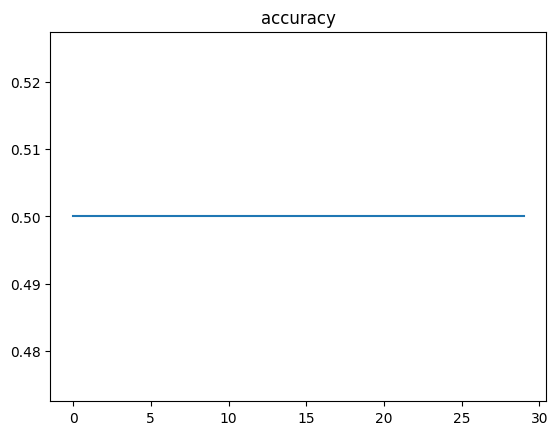

In [146]:
%matplotlib inline
plt.plot(ls)
plt.show()

plt.plot(ac)
plt.title("accuracy")

  0%|                                                                                 | 0/156 [00:00<?, ?it/s]/home/kushalk/python-venvs/stor566/lib/python3.9/site-packages/torch/nn/modules/rnn.py:471: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.rnn_tanh(input, hx, self._flat_weights, self.bias, self.num_layers,
100%|███████████████████████████████████████████████████████████████████████| 156/156 [00:05<00:00, 28.07it/s]


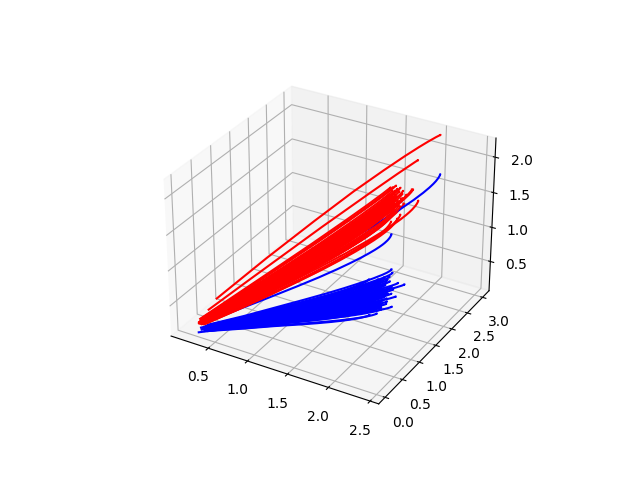

In [147]:
%matplotlib ipympl
inputs = all_targets.swapaxes(1, 2)[:, 0, :].reshape(156, 1, 4)
preds_pruned = plot_preds(prune_rnn_no_ascent, inputs)

## As you can see the pruned model produces garbage in comparison, less directionality. 

# Before re-training, first use gradient explosion for a few epochs before re-training to get out of the minima that was optimized for the previous network structure

In [160]:
lr = 0.05

prune_rnn_ascent, ls, ac = train(
    model=prune_rnn_ascent,
    targets=all_targets,
    optimizer=optim.Adam(prune_rnn_ascent.parameters(), lr),
    lr0=lr,
    loss_func=nn.MSELoss(),
    n_epochs=3,
    gradient_ascent=True,
    return_accuracy=True
)

  0%|                                                                                   | 0/3 [00:00<?, ?it/s]/home/kushalk/python-venvs/stor566/lib/python3.9/site-packages/torch/nn/modules/rnn.py:471: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.rnn_tanh(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/kushalk/python-venvs/stor566/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([156, 150, 3])) that is different to the input size (torch.Size([1, 156, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 33%|█████████████████████████  

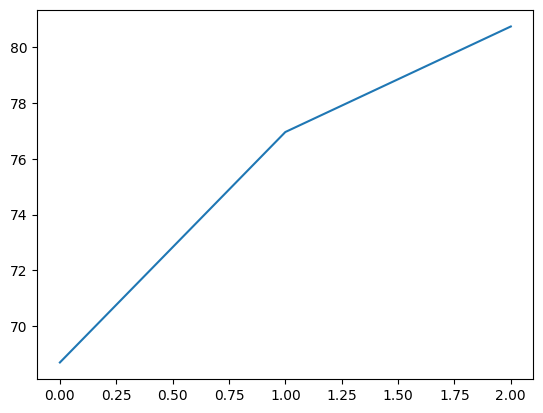

Text(0.5, 1.0, 'accuracy')

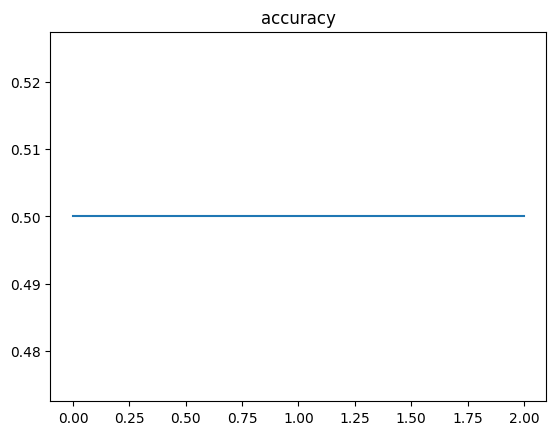

In [161]:
%matplotlib inline
plt.plot(ls)
plt.show()

plt.plot(ac)
plt.title("accuracy")

# Re-train the model

In [162]:
lr = 0.001

prune_rnn_ascent, ls, ac = train(
    model=prune_rnn_ascent,
    targets=all_targets,
    optimizer=optim.Adam(prune_rnn_ascent.parameters(), lr),
    lr0=lr,
    loss_func=nn.MSELoss(),
    n_epochs=40,
    gradient_ascent=False,
    return_accuracy=True
)

  0%|                                                                                  | 0/40 [00:00<?, ?it/s]/home/kushalk/python-venvs/stor566/lib/python3.9/site-packages/torch/nn/modules/rnn.py:471: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.rnn_tanh(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/kushalk/python-venvs/stor566/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([156, 150, 3])) that is different to the input size (torch.Size([1, 156, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  2%|█▊                         

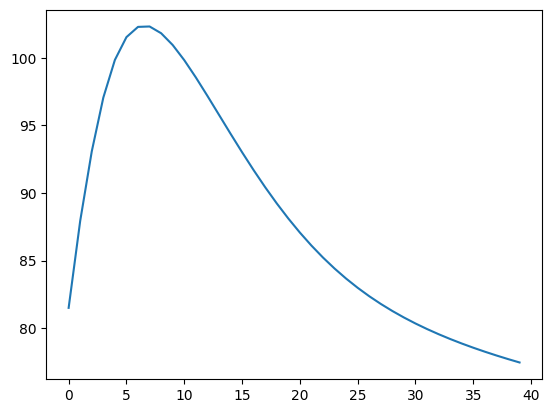

Text(0.5, 1.0, 'accuracy')

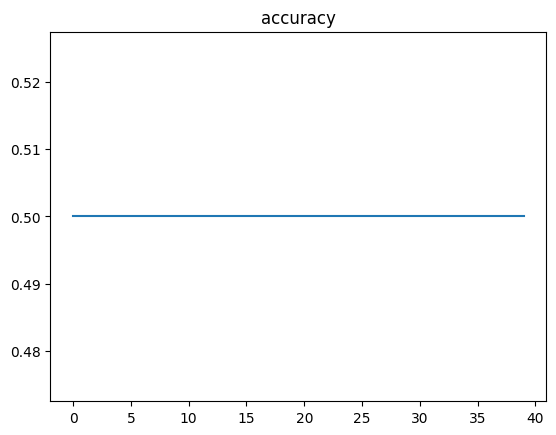

In [151]:
%matplotlib inline
plt.plot(ls)
plt.show()

plt.plot(ac)
plt.title("accuracy")

# Plot predictions using the pruned model!

  0%|                                                                                 | 0/156 [00:00<?, ?it/s]/home/kushalk/python-venvs/stor566/lib/python3.9/site-packages/torch/nn/modules/rnn.py:471: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.rnn_tanh(input, hx, self._flat_weights, self.bias, self.num_layers,
100%|███████████████████████████████████████████████████████████████████████| 156/156 [00:05<00:00, 28.71it/s]


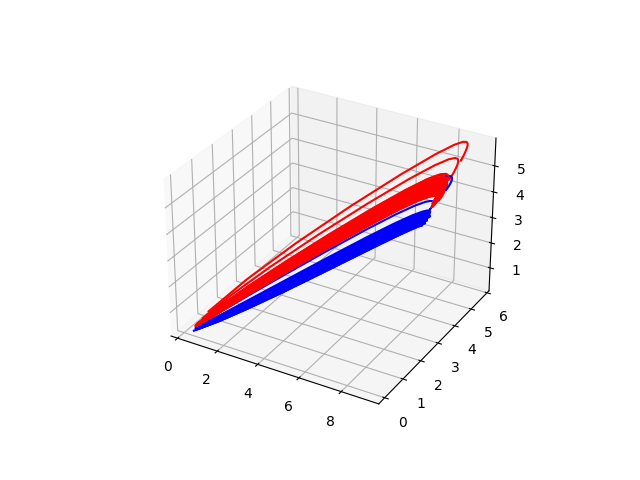

In [40]:
%matplotlib ipympl
inputs = all_targets.swapaxes(1, 2)[:, 0, :].reshape(156, 1, 4)
retrained_preds = plot_preds(prune_rnn, inputs)

# We get our left-right back (albeit not perfectly) but you can see that the pruning remains!!

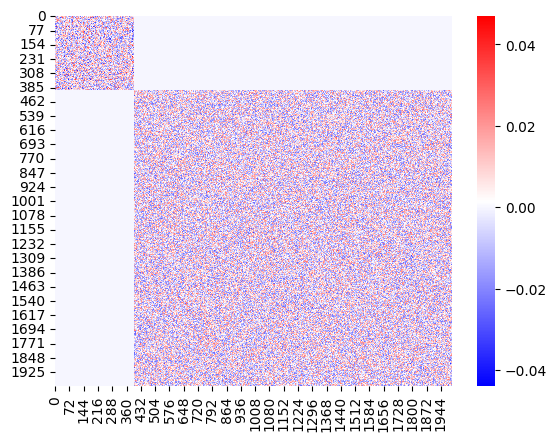

In [33]:
%matplotlib inline
sns.heatmap(prune_rnn.rnn.weight_hh_l0.detach().cpu().numpy(), cmap="bwr")
plt.show()